In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
# Reading the pre-processed data from the previous step (Data Wrangling.ipynb)
df = pd.read_csv('data/pre_processed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trap_id_id                160 non-null    int64  
 1   date                      160 non-null    object 
 2   crop_name                 160 non-null    object 
 3   region                    115 non-null    object 
 4   pest                      160 non-null    object 
 5   trap_count                160 non-null    float64
 6   is_sticky_sheet_replaced  160 non-null    bool   
 7   lat                       160 non-null    float64
 8   lon                       160 non-null    float64
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 10.3+ KB


In [93]:
df.loc[:, 'date'] = pd.to_datetime(df['date'])

In [88]:
# Let see how many unique fields we have
df['trap_id_id'].value_counts()

27     21
100    21
94     20
112    19
110    17
84     16
108    16
93     15
89     13
114     2
Name: trap_id_id, dtype: int64

In [89]:
df.crop_name.value_counts()

Brussels sprout    92
Broccoli           68
Name: crop_name, dtype: int64

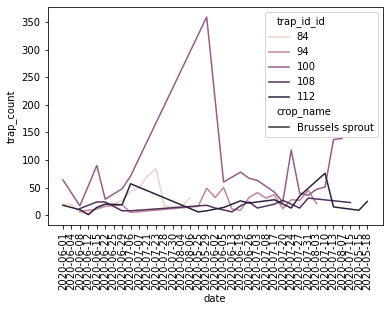

In [90]:
crop = 'Brussels sprout'
g = sns.lineplot(data=df.query('crop_name == @crop'), x="date", y="trap_count", hue="trap_id_id", style='crop_name')
g = plt.xticks(rotation=90)

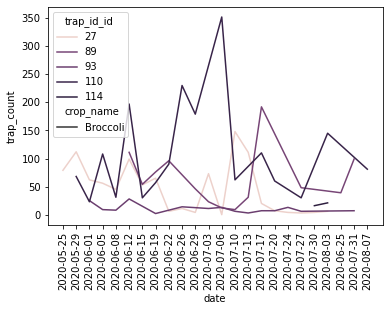

In [91]:
crop = 'Broccoli'
g = sns.lineplot(data=df.query('crop_name == @crop'), x="date", y="trap_count", hue="trap_id_id", style='crop_name')
g = plt.xticks(rotation=90)

* When the sticky sheet is replaced it does not have any affect on the trap count for the date it is replaced but it migh affect the trap counts for the following date(s) when the trap count recorded.

* Therefore we can calculate the number of days passed since the last time sticky sheet replaced for each field and use it as a predictor for trap count prediction.

* For the initial reading I will calculate the average number of days for the sticky sheet replacement

* If sticky sheet is not replaced number of pest trapped would be cumulative. However I assume that when trap count is recorded the previous reading is substracted from the current reading. The fact that in som cases trap counts decreases in subsequential readings even though sticky sheet is not replaced supports this assumption.

In [94]:
ax = df['date'].loc[1] - df['date'].loc[0] 
ax.days

4

### Creating Time-Delta feature to account for the days passed since the last time the sticky sheet is replaced
**Variables**: 
1. `df_trap_id`: a new data frame which is a subset of `df`. filtered using `df.query('trap_id_id == @unique_id}')` where `unique_id` refers to one of the trap id.
2. `df_trap_id['time_delta]`: A new Column, The number of days passed since the last time sticky sheet is replaced
3. `list_df_stack`: An empty list. The 2nd step is repeated for each trap id and the final `df_trap_id`'s appended to this list 

#### Steps
* Filter df for each trap id and create a new df_trap_id.
* Loop through the rows of df_trap_id
* At reach row calculate the days passed since the last time sticky sheet is replaced using the form_submission_date and `is_sticky_sheet_replaced` columns
* Write this number of days in the new column time_delta
* Append the the df_trap_id in to `list_df_stack` 

In [95]:
df.trap_id_id.unique()

array([ 27,  84,  89,  93,  94, 100, 108, 110, 112, 114], dtype=int64)

In [146]:
# let's create a time delta variable to account for the date passed since the last time the sticky sheet is replaced
#Let's create an empty list to append data for each unique field
list_df_stack = list()
for trap_id in df.trap_id_id.unique():
    df_trap_id = df.query('trap_id_id == @trap_id')
    
    # The first renewal date is unkown. 
    prev_renew_date = None # previous renewed date
    days_passed_list = []
    for i,current_date in enumerate(df_trap_id['date']):
        is_sticky_sheet_replaced = df_trap_id.iloc[i]['is_sticky_sheet_replaced']
        # if prev_renew_date is None sticky sheet has not been renewed at this stage
        if prev_renew_date == None:
            days_passed_list.append(np.nan)
        elif prev_renew_date != None:
            # then calculate the time delta between this time step and the previous renewed date
            time_delta = current_date - prev_renew_date
            days_passed_list.append(time_delta.days)


        # Let's update the prev_renew_date if sticky sheet is renewed at this time    
        if is_sticky_sheet_replaced:
            prev_renew_date = current_date
        
    # Now let's calculate the mean time_date to fill the initial value.
    try:
        mean_delta = round(np.nanmean(days_passed_list))
    #If sticky sheet has never been chnaged in a field above step will give ValueError
    # In that case simply replace mean_delta with 7 which is the usual suggested time to replace sticky sheet
    # and consistent with this data
    except ValueError:
        mean_delta = 7
    # Loop thorugh the rows again to impute the missing values
    for i,t_delta in enumerate(days_passed_list):
        if pd.isna(days_passed_list[i]):
            # Replace the first value with the average time_delta for this field
            if i == 0:
                days_passed_list[i] = mean_delta
            # replace the other missing values by calculating time_delta with the first recorded date and sum it with the initial time delta
            elif i > 0:
                # calculate time delta
                time_delta = df_trap_id.iloc[i]['date'] - df_trap_id.iloc[0]['date']
                days_passed = time_delta.days + mean_delta
                days_passed_list[i] = days_passed
        else:
            break

    df_trap_id.loc[:,'time_delta'] = days_passed_list
    list_df_stack.append(df_trap_id)
    print(trap_id)
    print(days_passed_list)
df = pd.concat(list_df_stack)

c:\Users\kurt_\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\kurt_\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\kurt_\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

27
[4, 4, 3, 7, 3, 7, 3, 7, 3, 4, 3, 4, 3, 4, 3, 7, 3, 4, 3, 6, 4]
84
[13, 16, 4, 8, 11, 18, 3, 7, 14, 15, 29, 31, 5, 7, 12, 14]
89
[12, 15, 19, 22, 25, 29, 33, 36, 40, 43, 4, 14, 18]
93
[4, 8, 11, 15, 22, 29, 36, 39, 43, 46, 50, 53, 57, 60, 4]
94
[5, 9, 4, 7, 3, 8, 2, 6, 3, 7, 3, 7, 3, 5, 9, 3, 7, 3, 7, 3]
100
[12, 15, 4, 7, 11, 3, 7, 10, 14, 17, 21, 24, 28, 3, 7, 10, 14, 17, 21, 3, 7]
108
[10, 4, 10, 5, 7, 11, 14, 18, 3, 7, 3, 12, 14, 17, 7, 11]
110
[6, 3, 7, 10, 4, 3, 7, 3, 4, 3, 7, 4, 11, 3, 10, 17, 4]
112
[12, 15, 22, 26, 3, 7, 10, 14, 3, 7, 10, 14, 17, 24, 28, 3, 7, 14, 17]
114
[7, 11]


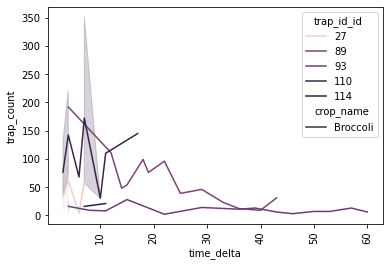

In [147]:
crop = 'Broccoli'
g = sns.lineplot(data=df.query('crop_name == @crop'), x="time_delta", y="trap_count", hue="trap_id_id", style='crop_name')
g = plt.xticks(rotation=90)

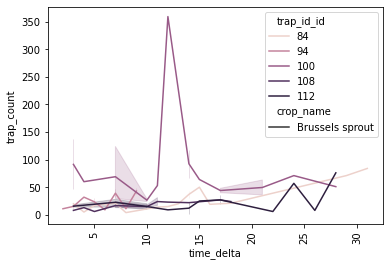

In [150]:
crop = 'Brussels sprout'
g = sns.lineplot(data=df.query('crop_name == @crop'), x="time_delta", y="trap_count", hue="trap_id_id", style='crop_name')
g = plt.xticks(rotation=90)

<AxesSubplot:>

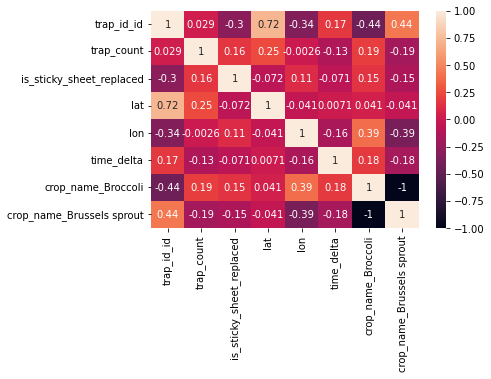

In [155]:
sns.heatmap(pd.get_dummies(df, columns=['crop_name']).corr(), annot=True)

## Exploring the Data
1. The locations of the fields
2. How frequently the sticky sheets are replaced at each field
3. The average number of traps at each side
4. Trends of traps at each side
5. Put the trap counts on the map. there may be a correlation between the close sidesMRROR

In [ ]:
TH